<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [2]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

In [2]:
# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [31]:
df['date'] = pd.to_datetime(df['full_review_text'].apply(lambda x: re.findall('\d+/\d+/\d+', x)[0]))
df.head()

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,2016-11-25
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,2016-12-02
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,2016-11-30
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,2016-11-25
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,2016-12-03


In [32]:
df['star_rating'] = df['star_rating'].apply(lambda x: x.strip(' star rating')).apply(float).apply(int)
df.head()

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03


In [33]:
df.loc[df['star_rating'] >= 4, ['good']] = 1
df.loc[df['star_rating'] < 4, ['good']] = 0
df['good'] = df['good'].astype(int)
df.head()

,coffee_shop_name,full_review_text,star_rating,date,good
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25,1
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02,1
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30,1
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25,0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03,1


In [34]:
df['check_ins'] = df['full_review_text'].str.findall('\d check-in')
for i, num in enumerate(df['check_ins']):
  if num:
    df.loc[i, 'check_ins'] = int(num[0].strip(' check-in'))
  else:
    df.loc[i, 'check_ins'] = 0
df.head()

,coffee_shop_name,full_review_text,star_rating,date,good,check_ins
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25,1,1
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02,1,0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30,1,1
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25,0,0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03,1,1


In [51]:
def tokenize(text):
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = text.replace('checkin', '')
  text = re.sub(r'\s+', ' ', text)
  return text.lower().split()

In [52]:
df['tokens'] = df['full_review_text'].apply(lambda x: tokenize(x))
df.head()

,coffee_shop_name,full_review_text,star_rating,date,good,check_ins,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25,1,1,"[love, love, loved, the, atmosphere, every, co..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02,1,0,"[listed, in, date, night, austin, ambiance, in..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30,1,1,"[listed, in, brunch, spots, i, loved, the, ecl..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25,0,0,"[very, cool, decor, good, drinks, nice, seatin..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03,1,1,"[they, are, located, within, the, northcross, ..."


In [57]:
def count(tokens):
  word_counts = Counter()
  appearances = Counter()

  for token in tokens:
    word_counts.update(token)
    appearances.update(set(token))
  
  temp = zip(word_counts.keys(), word_counts.values())
  wc = pd.DataFrame(temp, columns = ['word', 'count'])

  temp2 = zip(appearances.keys(), appearances.values())
  ap = pd.DataFrame(temp2, columns = ['word', 'appearances'])

  df = wc.merge(ap, on='word')

  df['rank'] = df['count'].rank(method='first', ascending=False)

  df['pct_total'] = df['count'] / df['count'].sum()
  df = df.sort_values(by='rank')
  df['cum_pct_total'] = df['pct_total'].cumsum()

  df['appearances_pct'] = df['appearances'] / len(tokens)

  return df

In [59]:
count_df = count(df['tokens'])
count_df.head(10)

,word,count,appearances,rank,pct_total,cum_pct_total,appearances_pct
2,the,34809,6847,1.0,0.045528,0.045528,0.899028
13,and,26651,6864,2.0,0.034858,0.080386,0.901261
47,a,22756,6246,3.0,0.029764,0.110150,0.820116
17,i,20249,5532,4.0,0.026485,0.136634,0.726366
42,to,17164,5653,5.0,0.022450,0.159084,0.742253
6,of,12600,5100,6.0,0.016480,0.175564,0.669643
83,is,11999,4999,7.0,0.015694,0.191258,0.656381
7,coffee,10354,4877,8.0,0.013542,0.204800,0.640362
22,was,9707,3765,9.0,0.012696,0.217497,0.494354
72,in,9546,4563,10.0,0.012486,0.229982,0.599133


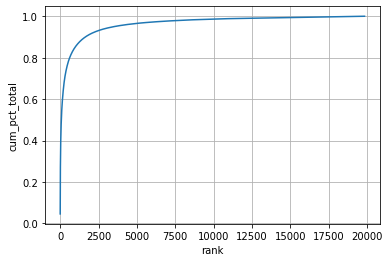

In [60]:
sns.lineplot(x='rank', y='cum_pct_total', data = count_df)
plt.grid()

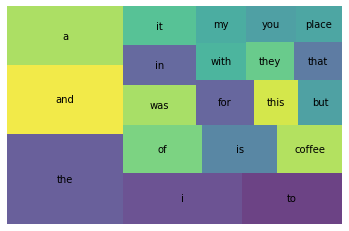

In [63]:
top20 = count_df[count_df['rank'] <= 20]
squarify.plot(sizes = top20['pct_total'], label = count_df['word'], alpha = 0.8)
plt.axis('off')
plt.show()

In [64]:
import spacy
nlp = spacy.load('en_core_web_md')

In [70]:
def spacy_tokens(text):
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = text.replace('checkin', '')
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  tokens = []
  for token in nlp(text):
    if (token.is_stop == False) & (token.is_punct ==  False):
      tokens.append(token.text.lower())
  return tokens


In [71]:
df['spacy_tokens'] = df['full_review_text'].apply(lambda x: spacy_tokens(x))
df.head()

,coffee_shop_name,full_review_text,star_rating,date,good,check_ins,tokens,spacy_tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25,1,1,"[love, love, loved, the, atmosphere, every, co...","[love, love, loved, atmosphere, corner, coffee..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02,1,0,"[listed, in, date, night, austin, ambiance, in...","[listed, date, night, austin, ambiance, austin..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30,1,1,"[listed, in, brunch, spots, i, loved, the, ecl...","[listed, brunch, spots, loved, eclectic, homey..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25,0,0,"[very, cool, decor, good, drinks, nice, seatin...","[cool, decor, good, drinks, nice, seating, ove..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03,1,1,"[they, are, located, within, the, northcross, ...","[located, northcross, mall, shopping, center, ..."


In [73]:
good_df = df[df['good'] == 1]
bad_df = df[df['good'] == 0]
print(f'Shape of original: {df.shape}, shape of good: {good_df.shape}, shape of bad: {bad_df.shape}.')

Shape of original: (7616, 8), shape of good: (6140, 8), shape of bad: (1476, 8).


In [77]:
count_good = count(good_df['spacy_tokens'])
count_good.head(20)

,word,count,appearances,rank,pct_total,cum_pct_total,appearances_pct
4,coffee,8235,3933,1.0,0.029485,0.029485,0.640554
71,place,4314,2939,2.0,0.015446,0.044931,0.478664
66,nt,3464,2187,3.0,0.012403,0.057333,0.356189
129,great,3453,2492,4.0,0.012363,0.069697,0.405863
193,good,3096,2192,5.0,0.011085,0.080782,0.357003
200,like,2212,1559,6.0,0.007920,0.088702,0.253909
139,s,2045,1578,7.0,0.007322,0.096024,0.257003
43,austin,1969,1547,8.0,0.007050,0.103073,0.251954
0,love,1725,1322,9.0,0.006176,0.109250,0.215309
155,friendly,1462,1399,10.0,0.005235,0.114484,0.227850


In [78]:
count_bad = count(bad_df['spacy_tokens'])
count_bad.head(20)

,word,count,appearances,rank,pct_total,cum_pct_total,appearances_pct
32,coffee,2119,944,1.0,0.026902,0.026902,0.639566
129,nt,1701,868,2.0,0.021596,0.048498,0.588076
34,place,1112,720,3.0,0.014118,0.062616,0.487805
2,good,877,596,4.0,0.011134,0.073750,0.403794
29,like,876,565,5.0,0.011122,0.084872,0.382791
54,food,484,310,6.0,0.006145,0.091016,0.210027
185,time,478,353,7.0,0.006069,0.097085,0.239160
64,great,466,344,8.0,0.005916,0.103001,0.233062
45,m,454,322,9.0,0.005764,0.108765,0.218157
26,service,445,345,10.0,0.005650,0.114415,0.233740


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

